In [1]:
#### This cell is to make spark work on a windows laptop
import os
import sys

# Path for spark source folder
os.environ['SPARK_HOME']="C:\spark-2.0.1-bin-hadoop2.7"

# Append pyspark  to Python Path
sys.path.append("C:\spark-2.0.1-bin-hadoop2.7\python")
sys.path.append("C:\spark-2.0.1-bin-hadoop2.7\python\lib\py4j-0.10.3-src.zip")
#os.environ['SPARK_EXECUTOR_MEMORY']="5G"

try:
    from pyspark import SparkContext
    from pyspark import SparkConf
    print ("Successfully imported Spark Modules")

except ImportError as e:
    print ("Can not import Spark Modules", e)
    sys.exit(1)

# Initialize SparkContext
sc = SparkContext('local')
words = sc.parallelize(["scala","java","hadoop","spark","akka"])
print (words.count())
print(words.countByValue())

Successfully imported Spark Modules
5
defaultdict(<class 'int'>, {'akka': 1, 'spark': 1, 'java': 1, 'hadoop': 1, 'scala': 1})


In [2]:
words = sc.parallelize([(2,"scala"),(0,"java"),(2,"hadoop"),(0,"spark"),(1,"akka")])
words1 = words.partitionBy(3, lambda x: x)
def f(idx,it):
    yield list(it)
    

words1.mapPartitionsWithIndex(f).collect()

[[(0, 'java'), (0, 'spark')], [(1, 'akka')], [(2, 'scala'), (2, 'hadoop')]]

In [3]:
import os
import sys
import re
from IPython.display import display
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import time as time
from matplotlib.patches import Rectangle
import datetime
import ast
from operator import add
import math

# First step: cleaning the data

In [4]:
input_path = "train.csv"
raw_data = sc.textFile(input_path)
print("number of rows before cleaning:", raw_data.count())

# extract the header
header = raw_data.first()

# replace invalid data with NULL and remove header
cleaned_data = raw_data.filter(lambda row: row != header)

print("number of rows after cleaning:", raw_data.count())
print("Number of partitions: " + str(raw_data.getNumPartitions()))

sqlContext = SQLContext(sc)

number of rows before cleaning: 188319
number of rows after cleaning: 188319
Number of partitions: 2


We now need to put our data into a dataframe, so that it's going to be easier to plot graphs and get a better insight into our data.

In [5]:
header

'id;cat1;cat2;cat3;cat4;cat5;cat6;cat7;cat8;cat9;cat10;cat11;cat12;cat13;cat14;cat15;cat16;cat17;cat18;cat19;cat20;cat21;cat22;cat23;cat24;cat25;cat26;cat27;cat28;cat29;cat30;cat31;cat32;cat33;cat34;cat35;cat36;cat37;cat38;cat39;cat40;cat41;cat42;cat43;cat44;cat45;cat46;cat47;cat48;cat49;cat50;cat51;cat52;cat53;cat54;cat55;cat56;cat57;cat58;cat59;cat60;cat61;cat62;cat63;cat64;cat65;cat66;cat67;cat68;cat69;cat70;cat71;cat72;cat73;cat74;cat75;cat76;cat77;cat78;cat79;cat80;cat81;cat82;cat83;cat84;cat85;cat86;cat87;cat88;cat89;cat90;cat91;cat92;cat93;cat94;cat95;cat96;cat97;cat98;cat99;cat100;cat101;cat102;cat103;cat104;cat105;cat106;cat107;cat108;cat109;cat110;cat111;cat112;cat113;cat114;cat115;cat116;cont1;cont2;cont3;cont4;cont5;cont6;cont7;cont8;cont9;cont10;cont11;cont12;cont13;cont14;loss'

Our taget is the loss. The id isn't actually useful and will be removed later. "cat" means categorical feature and "cont" means a continuous feature. we will use that to create the data schema. Note that we'll convert strings in Ints since it's easier to manipulate them later. (In particular for partitioning).

In [6]:
names = header.split(";")

In [7]:
cat = names[1:117]
cont = names[117:-1]

In [8]:
def create_StructField(string):
    hint = string[:3]
    if hint == "cat":
        datatype = IntegerType()
    elif hint == "con":
        datatype = FloatType()
    elif hint == "id":
        datatype = IntegerType()
    elif hint == "los":
        datatype = FloatType()
    else:
        raise ValueError("Can\'t read this string:" + hint )

    return StructField(string, datatype, False)

In [9]:
structField_list = [create_StructField(string) for string in names]

In [10]:
data_schema = StructType(structField_list)

In [11]:
def tryeval(val,column_number):
    if column_number == 0:
        return int(val)
    elif 1 <= column_number <= 116:
        return val
    elif 117 <= column_number <= 131:
        return float(val)
    else:
        raise Exception("There is a big problem")

def to_tuple(string):
    list_of_strings = string.split(";")
    return tuple(tryeval(string, n) for n, string in enumerate(list_of_strings))

cleaned_data_splitted = cleaned_data.map(lambda x: to_tuple(x))

In [12]:
cleaned_data_splitted.count()

188318

Now, we'll try to convert the categorical values in integers as it's way easier to work with later on.

In [13]:
def to_tuples(list_):
    return tuple((string,) for string in list_)

def fusion(x, y):
    return tuple(tuple(set(xi + yi)) for xi, yi in zip(x,y))

list_of_dictionaries = []
a = cleaned_data_splitted.map(lambda x: to_tuples(x[1:117])).reduce(fusion)

In [14]:
sorted_tuples = tuple(tuple(sorted(tup)) for tup in a)

Now we have all the categories in order. We'll put them in a list of dictionaries as it makes it simpler to modify the RDD after that.

In [15]:
for tup in sorted_tuples:
    my_dict = dict()
    for idx, cat in enumerate(tup):
        my_dict[cat] = idx
    list_of_dictionaries.append(my_dict)

In [16]:
list_of_dictionaries[0]

{'A': 0, 'B': 1}

In [17]:
bListOfDictionaries = sc.broadcast(list_of_dictionaries)

In [18]:
def replace(row):
    strings = row[1:117]
    my_dicts = bListOfDictionaries.value
    tuple_of_ints = tuple( dict_[string] for dict_, string in zip(my_dicts, strings))
    return (row[0],) + tuple_of_ints + row[117:]

In [19]:
final_rdd = cleaned_data_splitted.map(replace)

we now have integers instead of "A" or "C" or any other string.

In [20]:
print(final_rdd.first())

(1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 1, 1, 3, 3, 1, 3, 2, 1, 3, 1, 0, 0, 0, 0, 0, 3, 1, 2, 4, 0, 2, 15, 1, 6, 0, 0, 8, 4, 6, 9, 6, 45, 28, 2, 19, 55, 0, 14, 269, 0.7263, 0.245921, 0.187583, 0.789639, 0.310061, 0.718367, 0.33506, 0.3026, 0.67135, 0.8351, 0.569745, 0.594646, 0.822493, 0.714843, 2213.18)


In [21]:
df = sqlContext.createDataFrame(final_rdd, schema = data_schema).coalesce(12).cache()

In [22]:
for i in range(33):
    df.select(names[4*i:4*i+4]).describe().show()

+-------+------------------+-------------------+-------------------+-------------------+
|summary|                id|               cat1|               cat2|               cat3|
+-------+------------------+-------------------+-------------------+-------------------+
|  count|            188318|             188318|             188318|             188318|
|   mean| 294135.9825614121|0.24834588302764474|0.43329368408755403|0.05482747267919158|
| stddev|169336.08486658783|0.43205462231767017| 0.4955316047813724|0.22764379214170746|
|    min|                 1|                  0|                  0|                  0|
|    max|            587633|                  1|                  1|                  1|
+-------+------------------+-------------------+-------------------+-------------------+

+-------+------------------+-------------------+-------------------+--------------------+
|summary|              cat4|               cat5|               cat6|                cat7|
+-------+---------

In [30]:
def plot_frequencies(column_idx, max_cat = 10):
    name = names[column_idx]
    a = df.groupBy(name).count().collect()
    pdf = pd.DataFrame(data=a).sort_values(0)
    l1 = pdf[0].tolist()[:10]
    l2 = pdf[1].tolist()[:10]
    plt.bar(range(len(l1)), l2)
    plt.xticks(np.arange(len(l1))+0.5,l1)
    plt.title("Frequencies of " + name)
    plt.show()

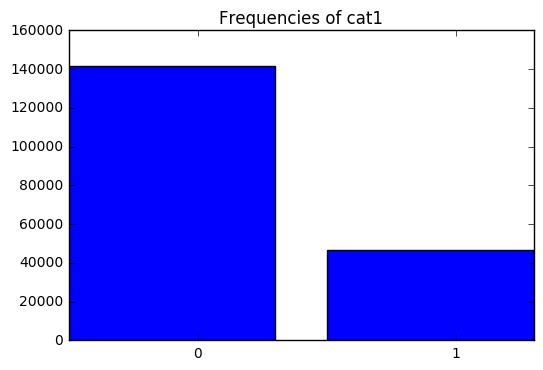

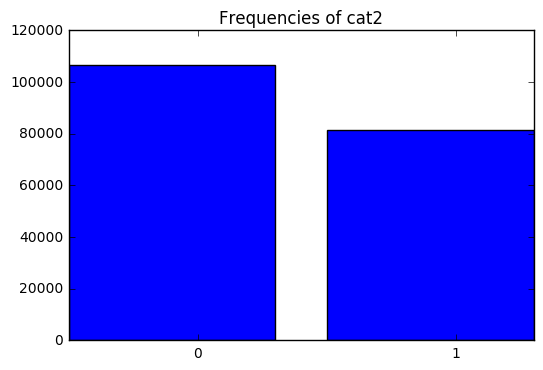

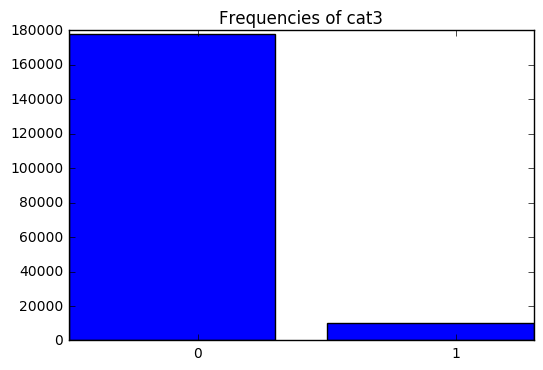

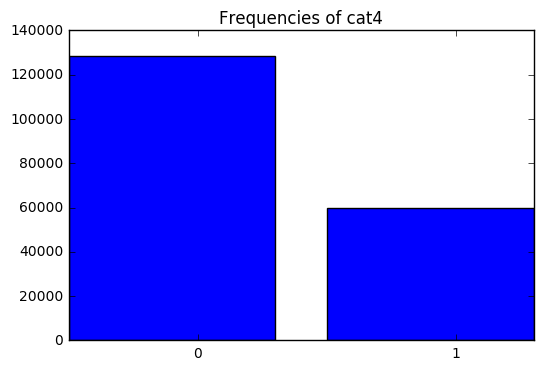

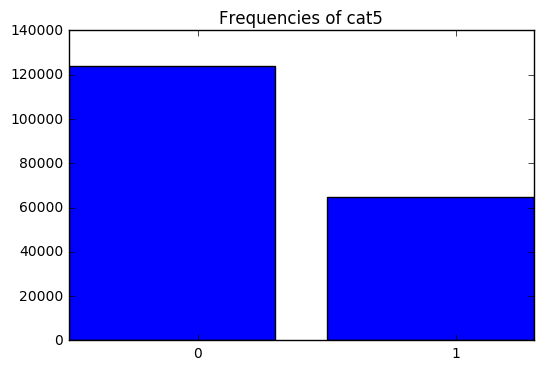

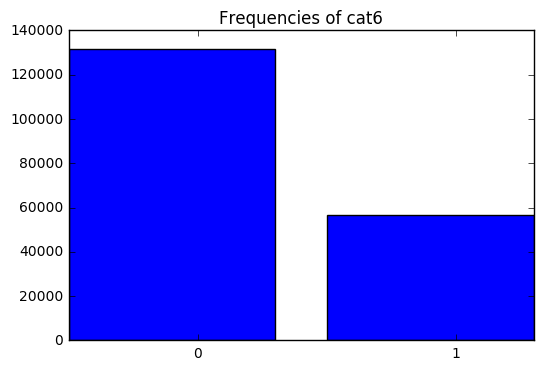

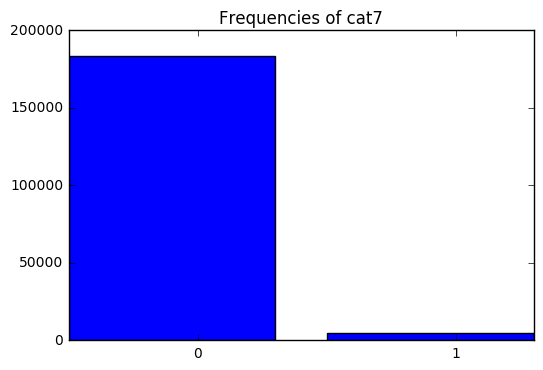

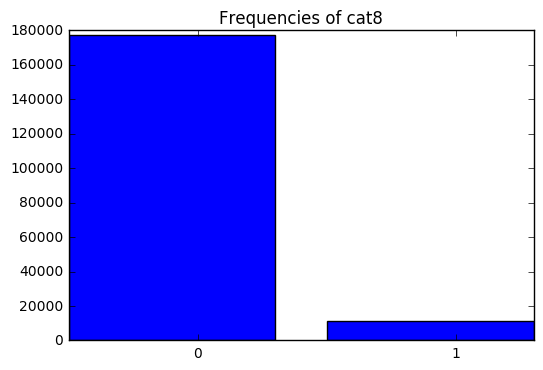

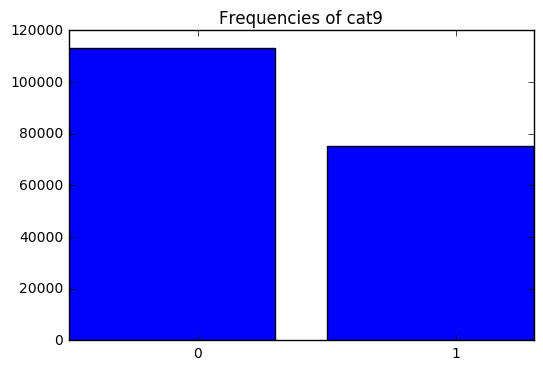

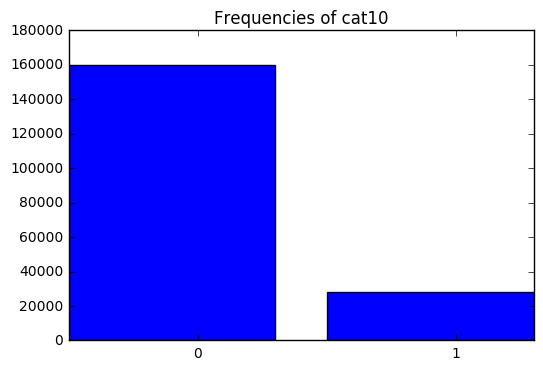

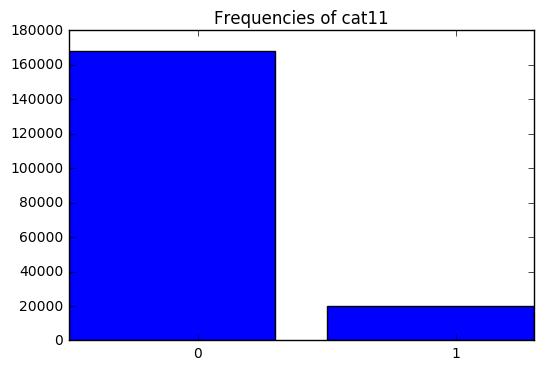

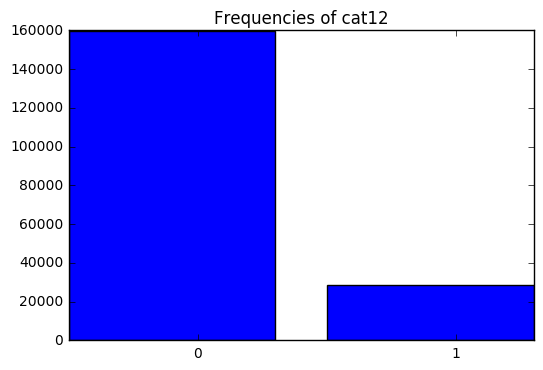

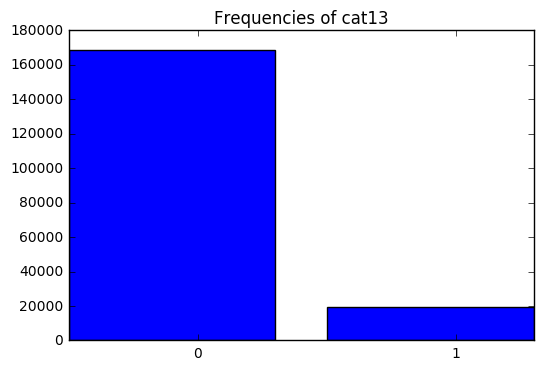

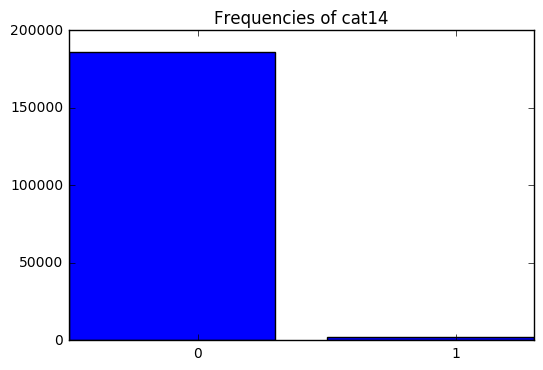

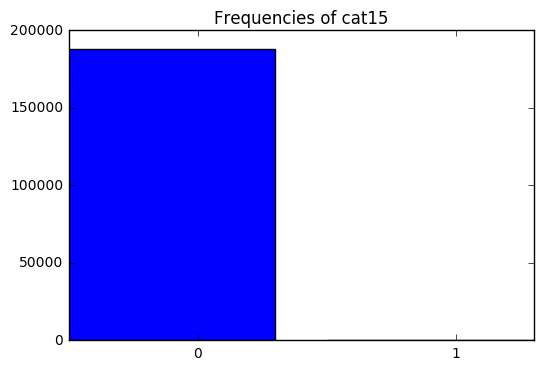

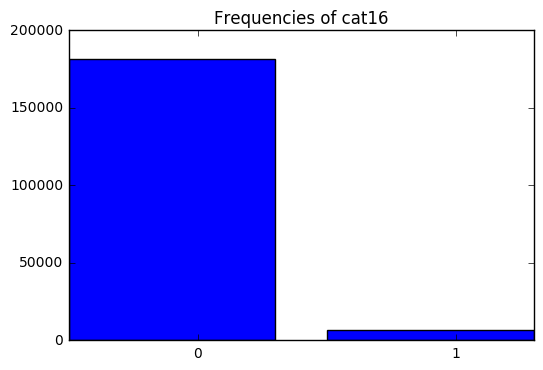

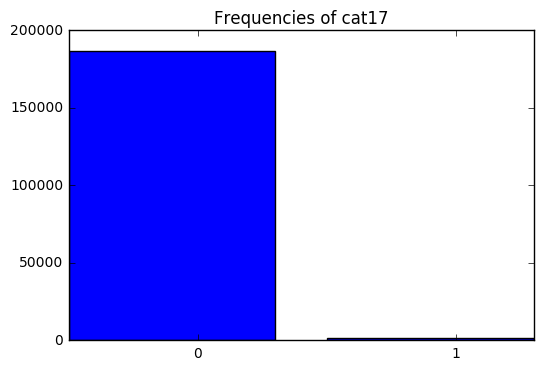

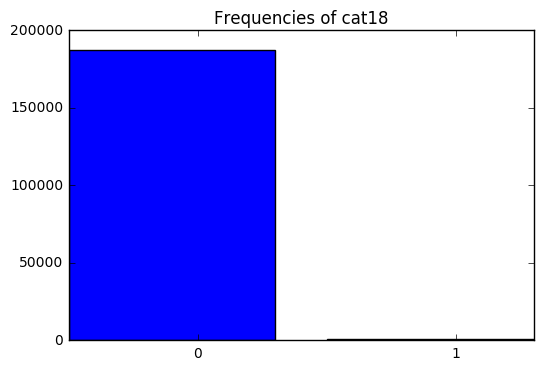

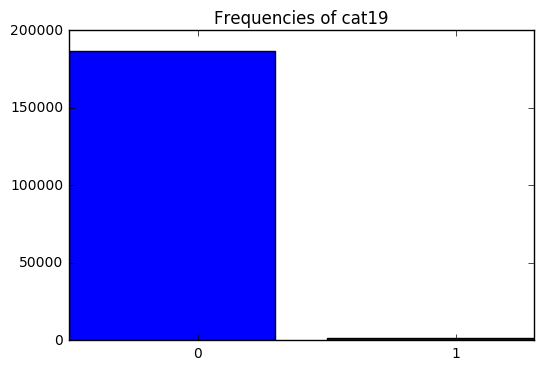

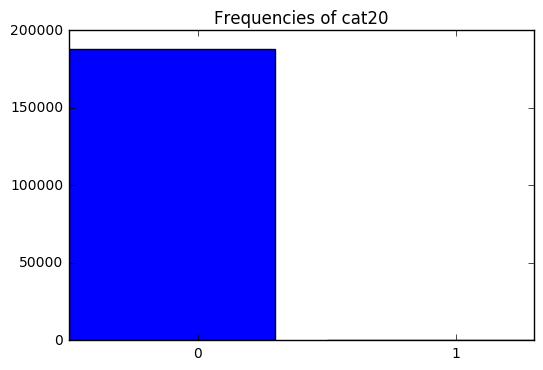

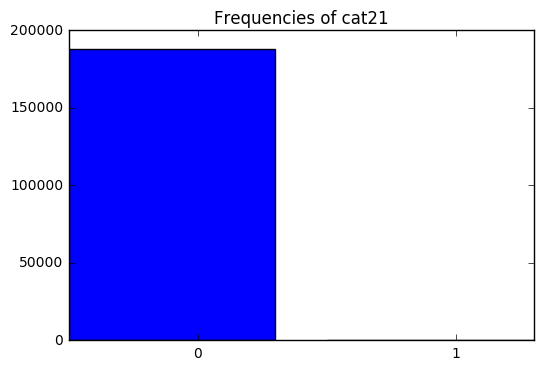

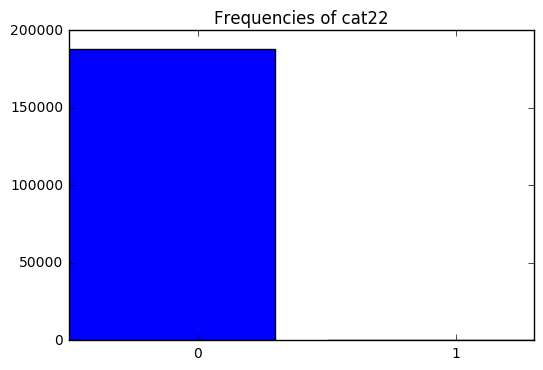

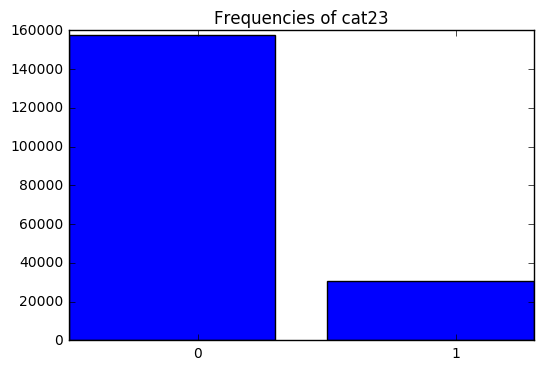

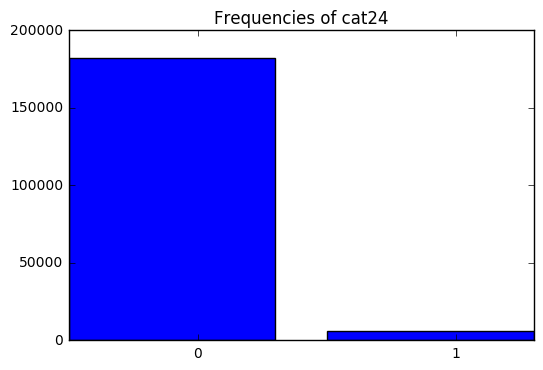

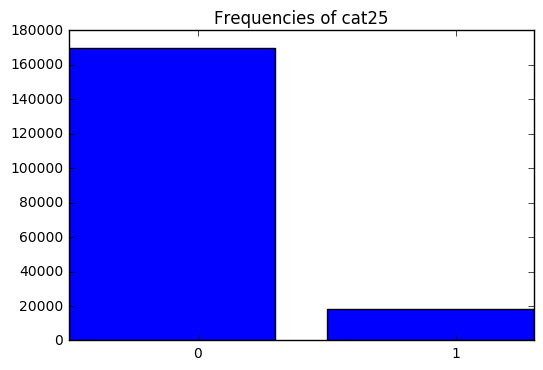

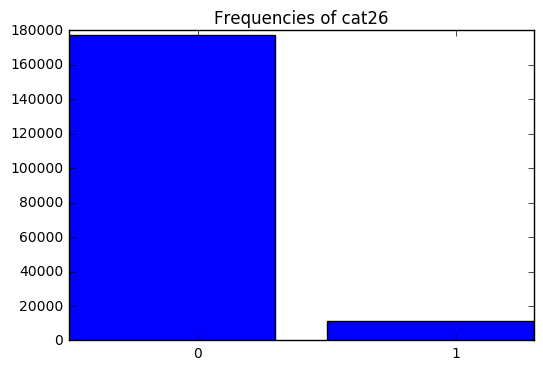

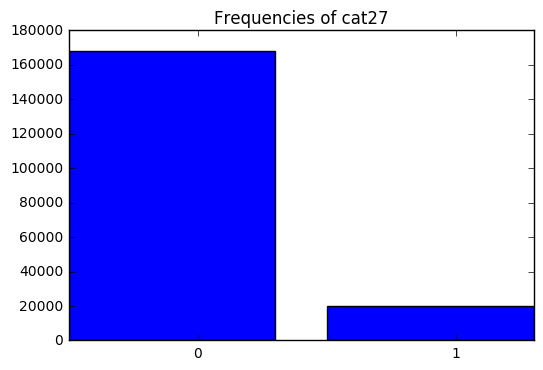

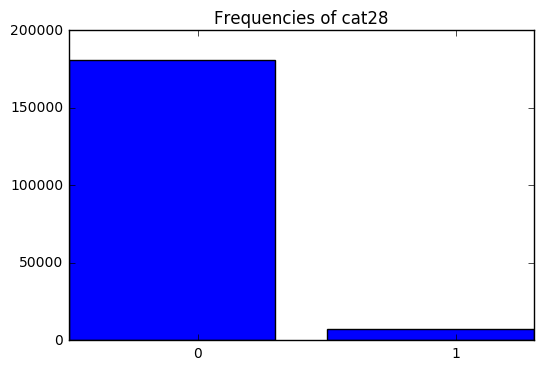

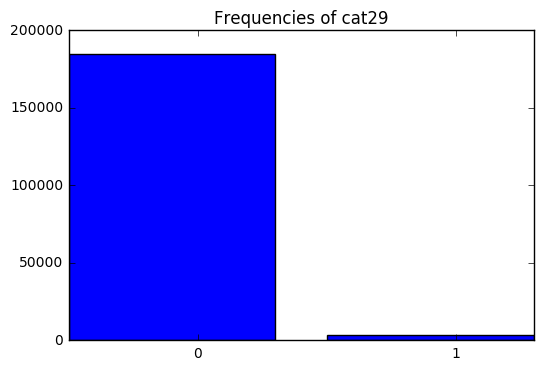

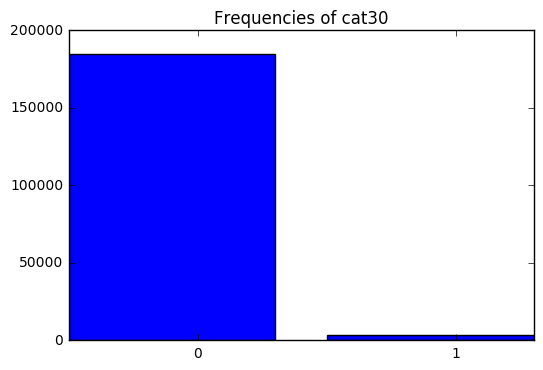

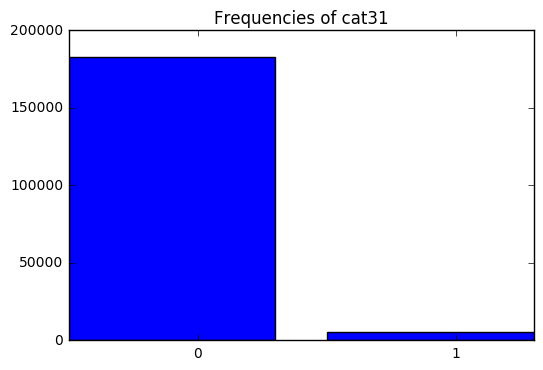

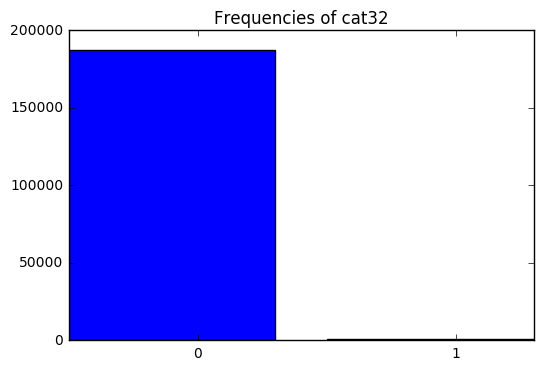

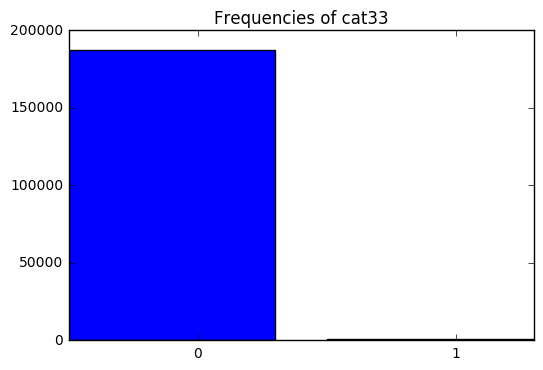

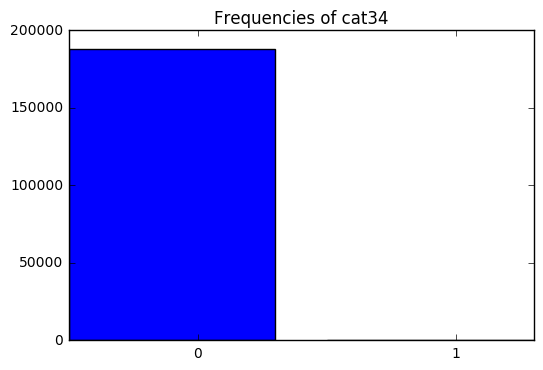

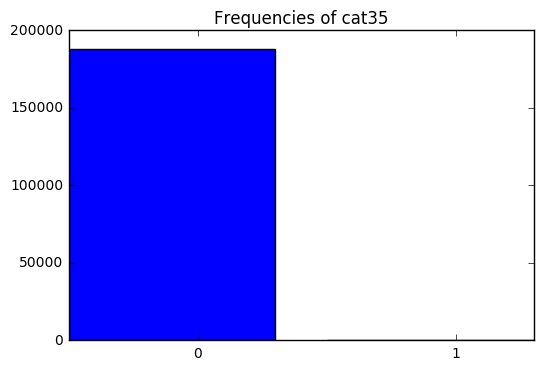

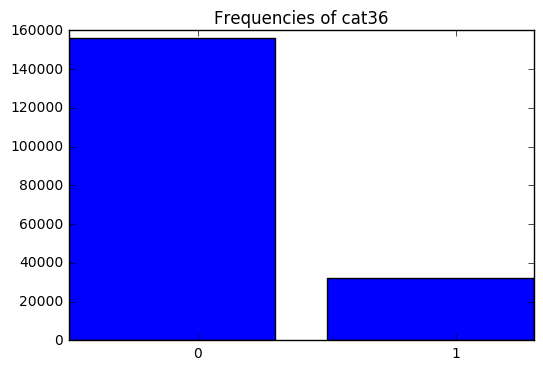

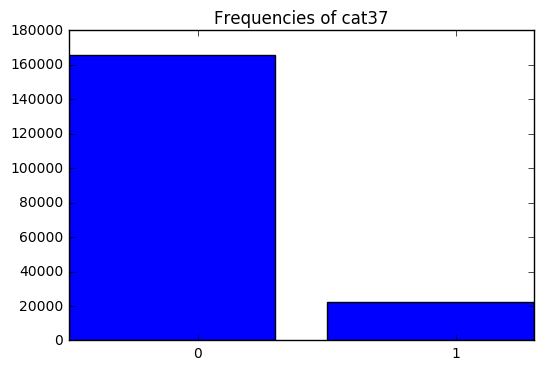

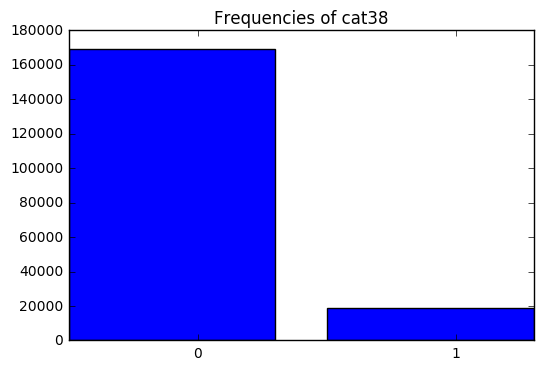

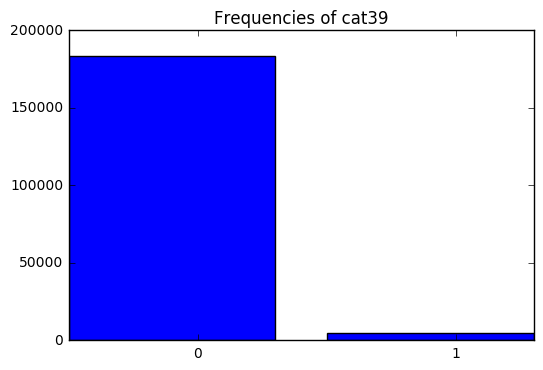

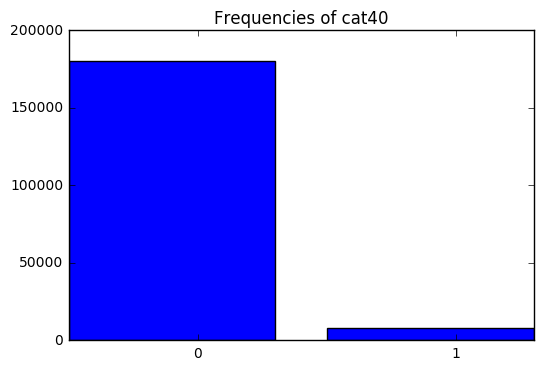

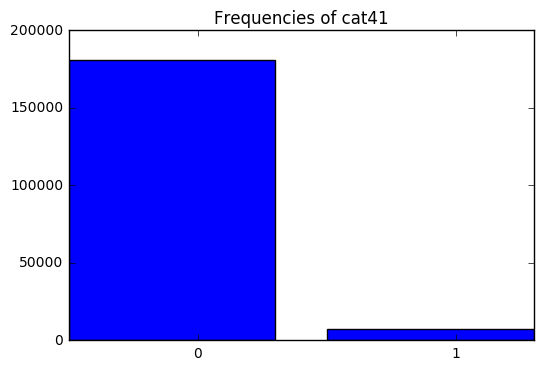

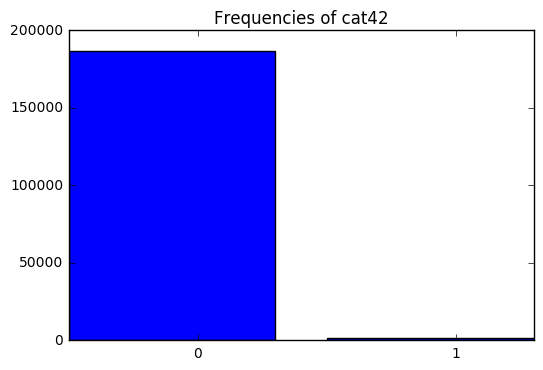

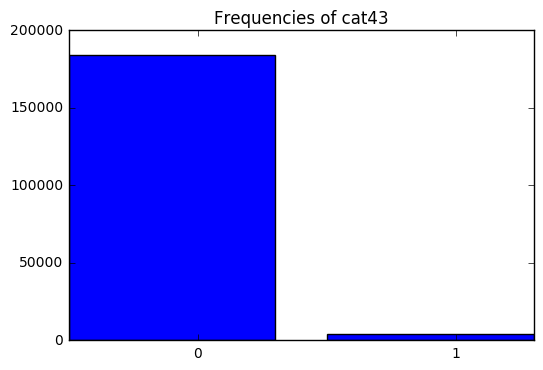

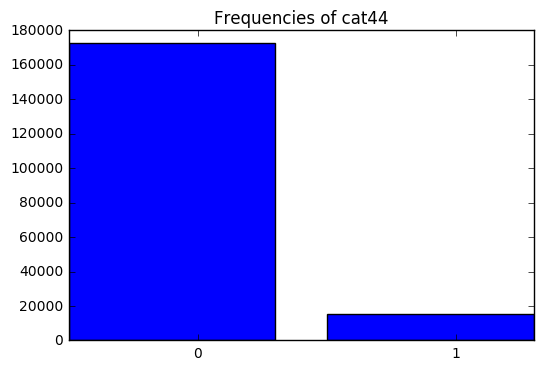

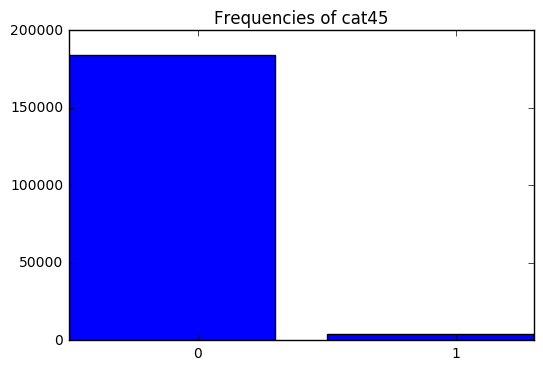

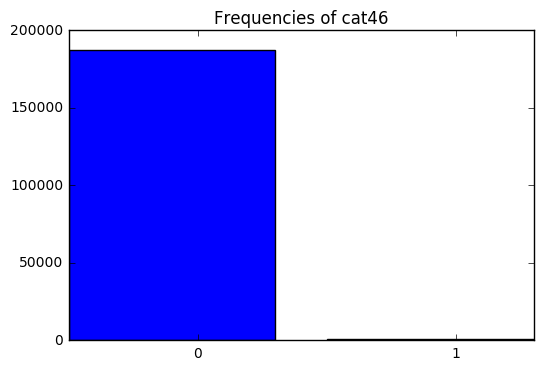

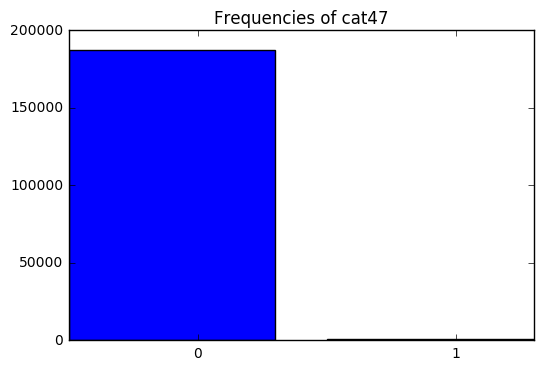

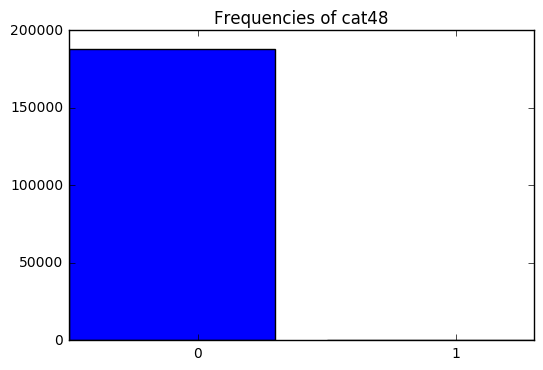

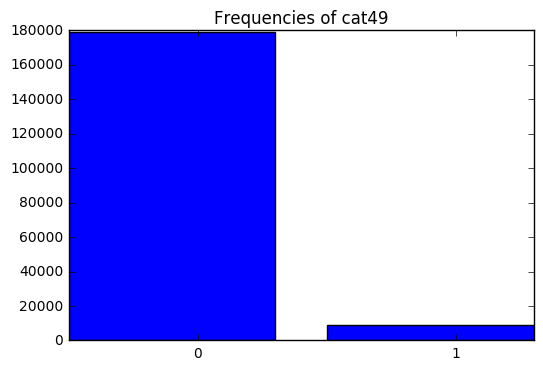

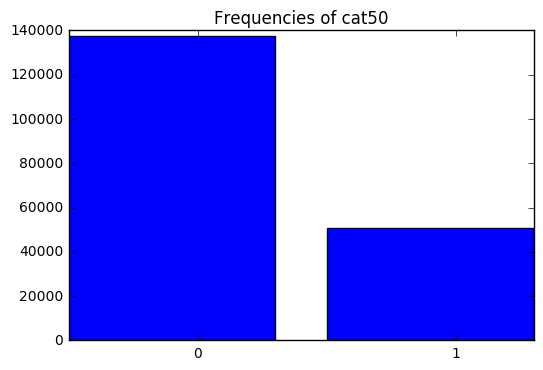

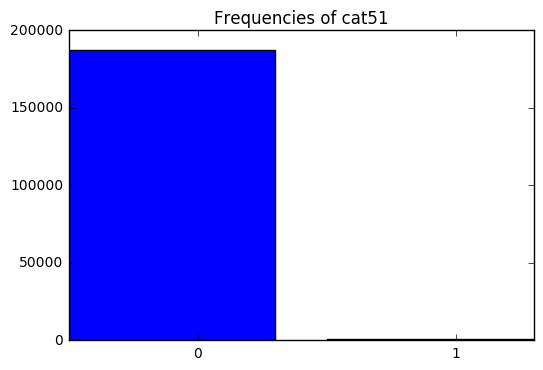

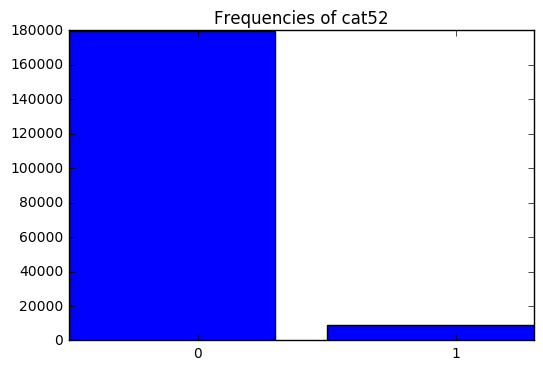

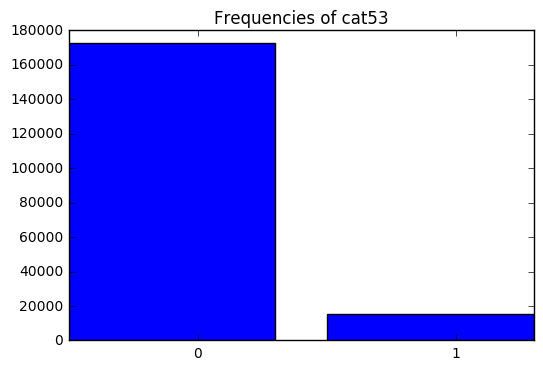

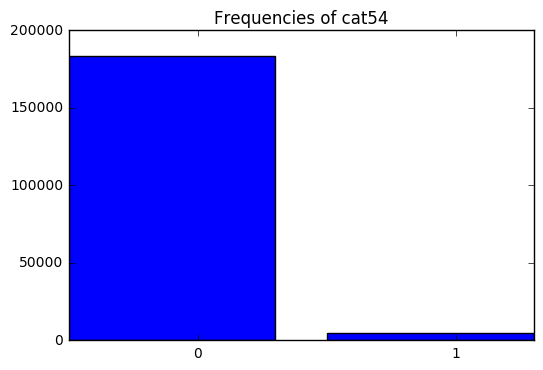

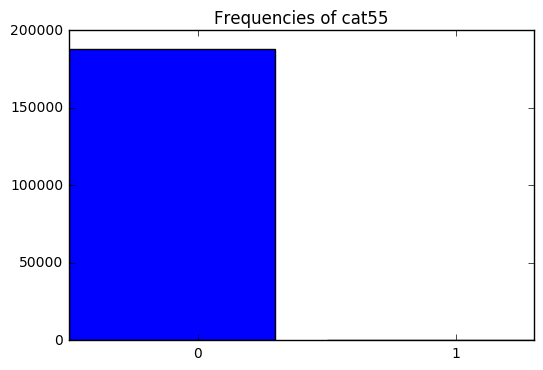

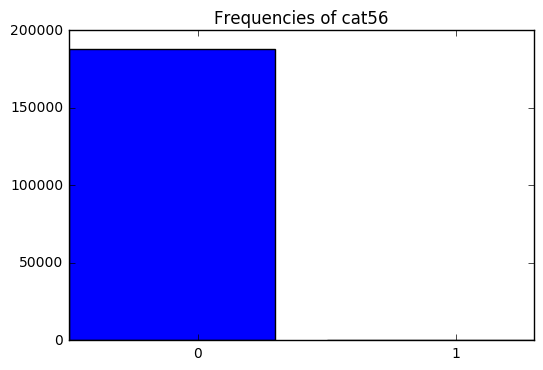

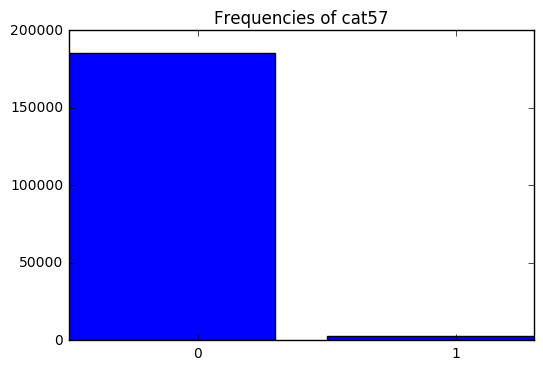

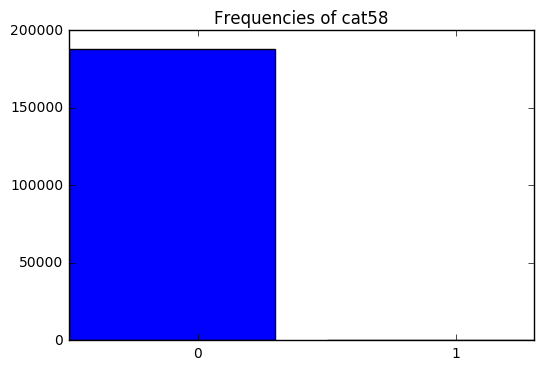

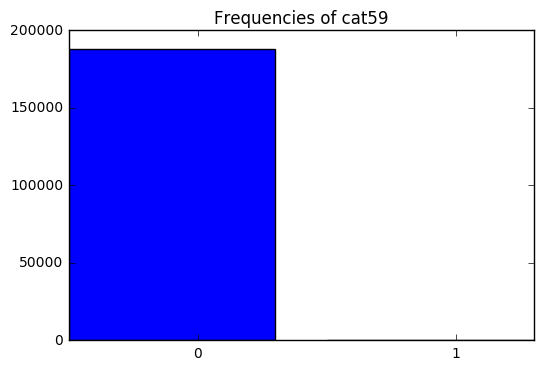

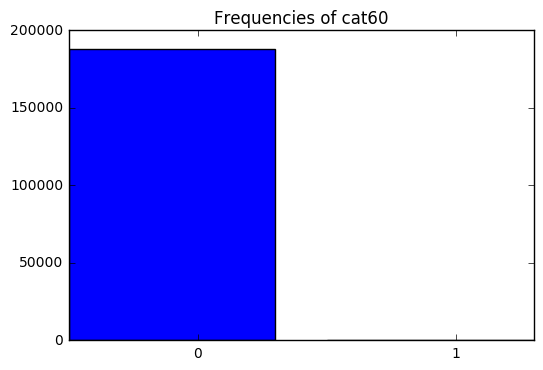

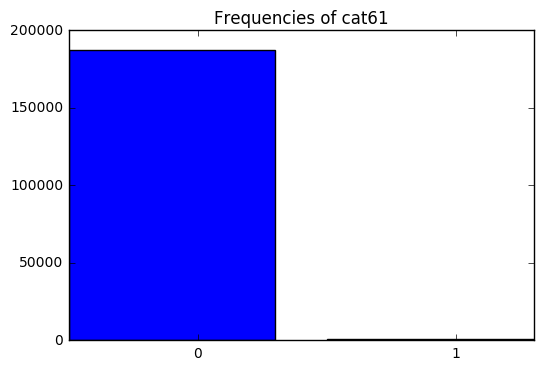

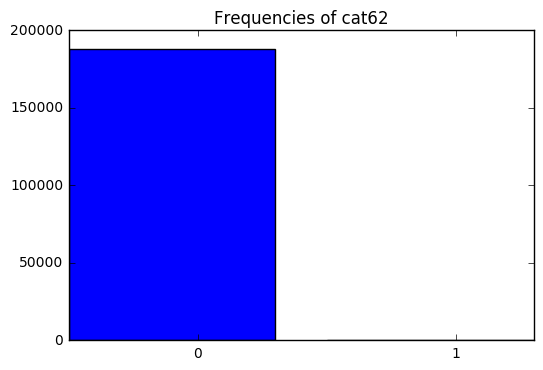

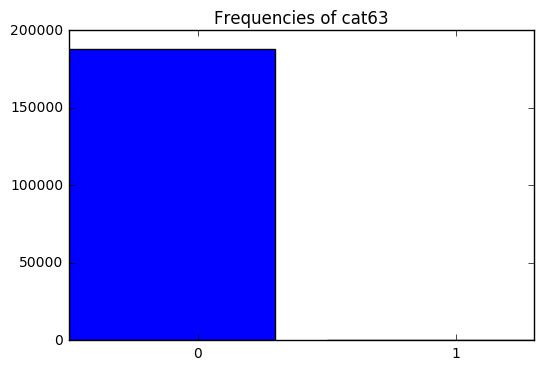

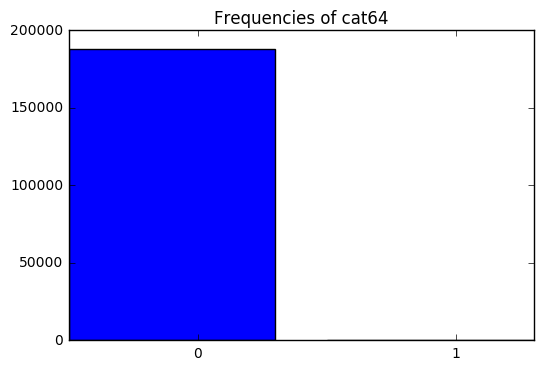

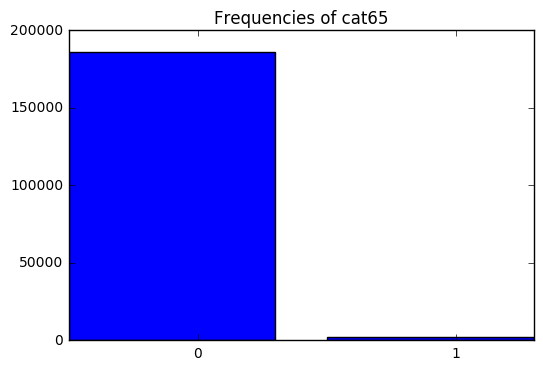

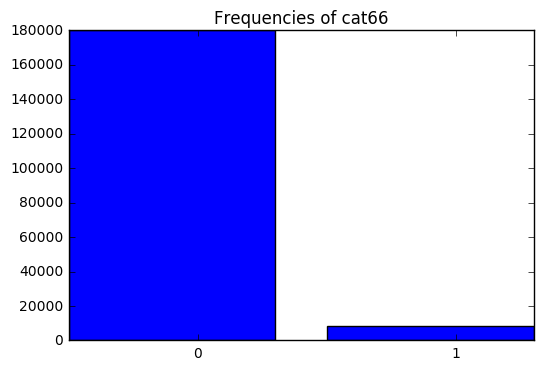

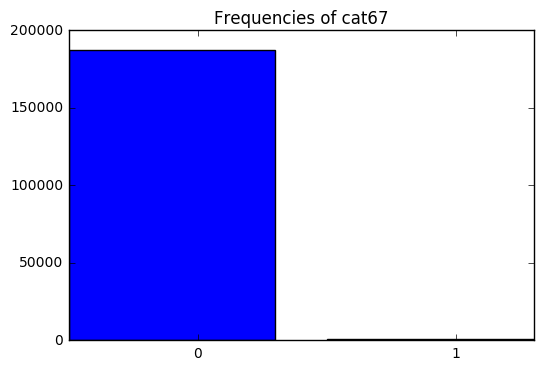

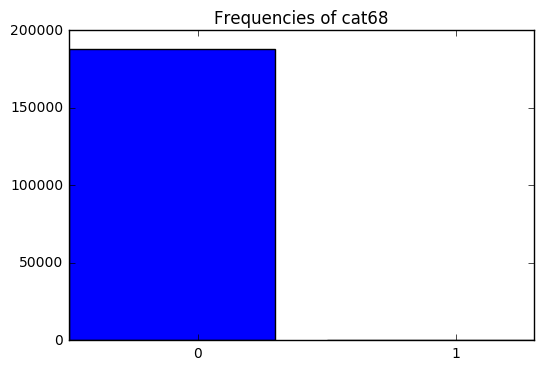

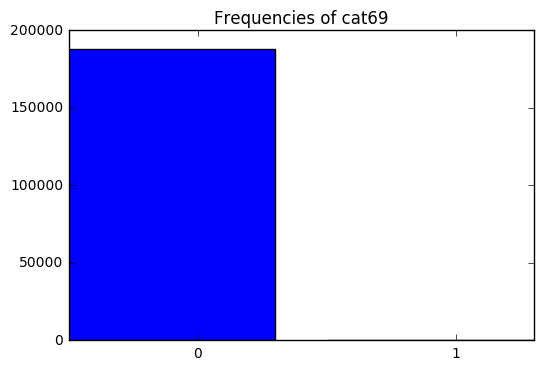

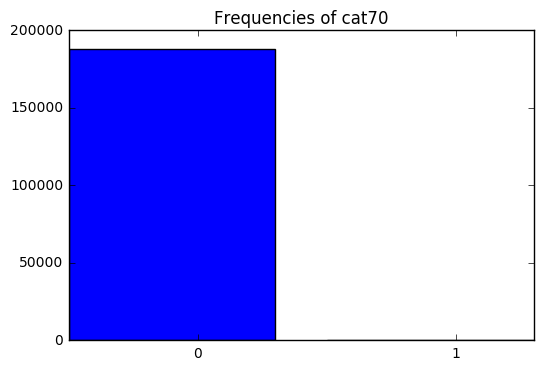

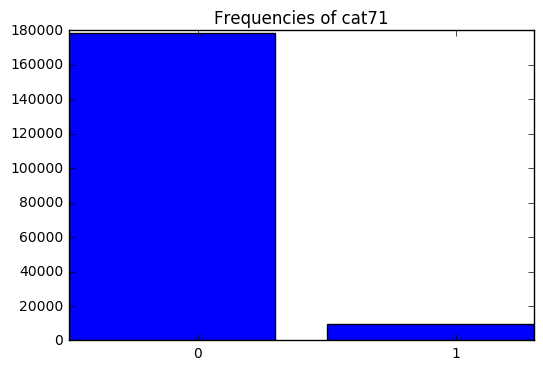

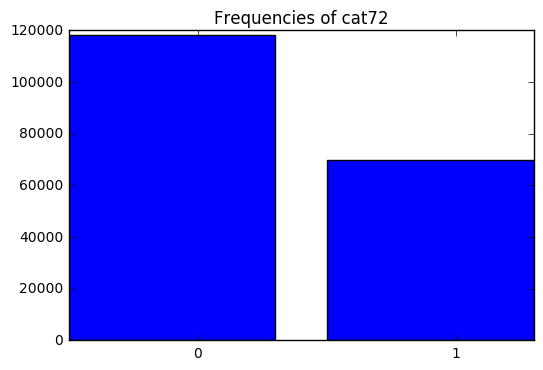

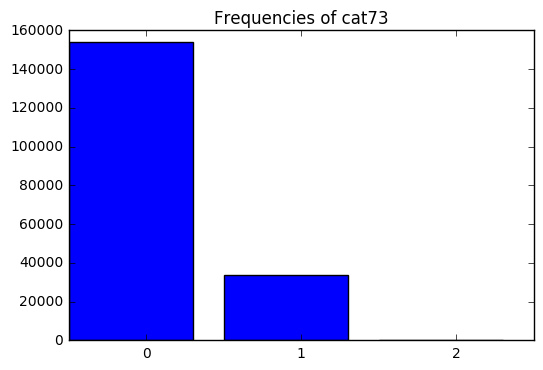

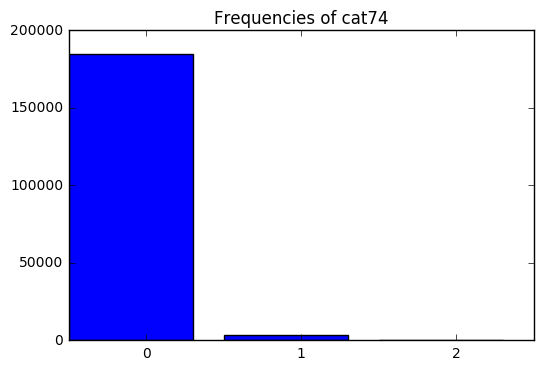

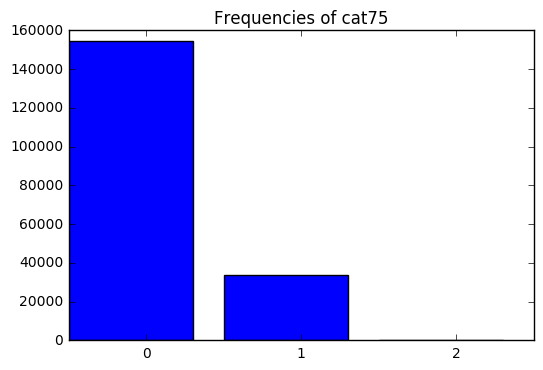

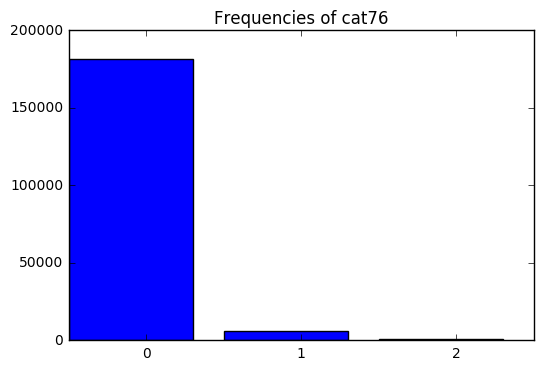

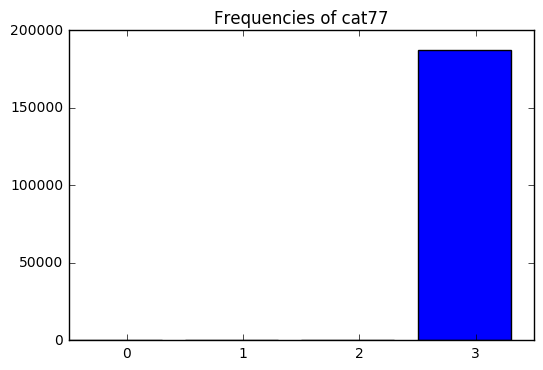

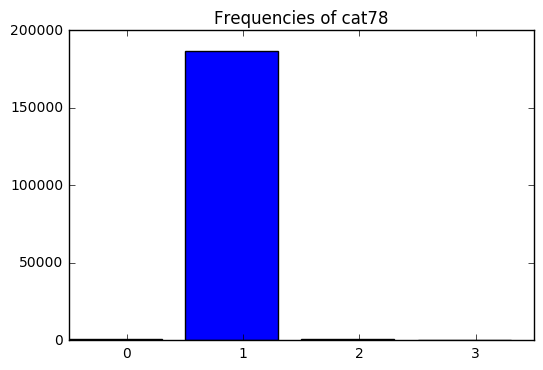

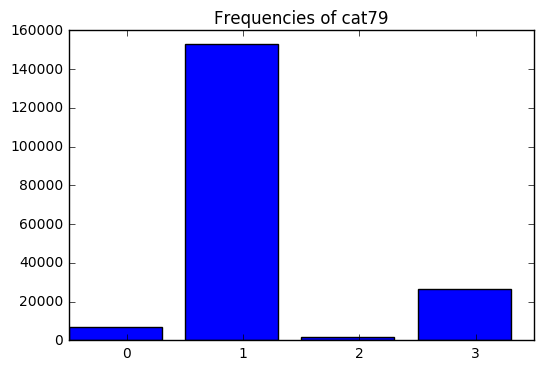

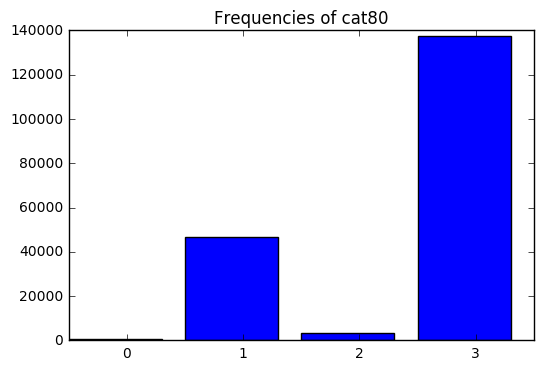

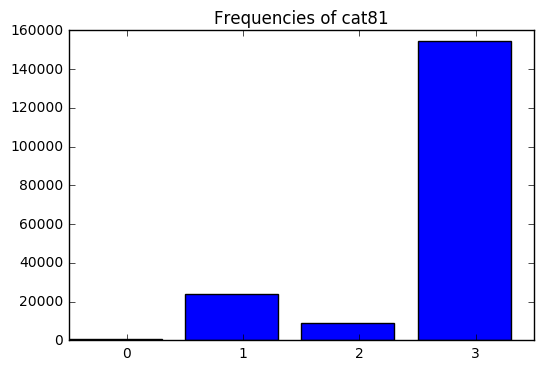

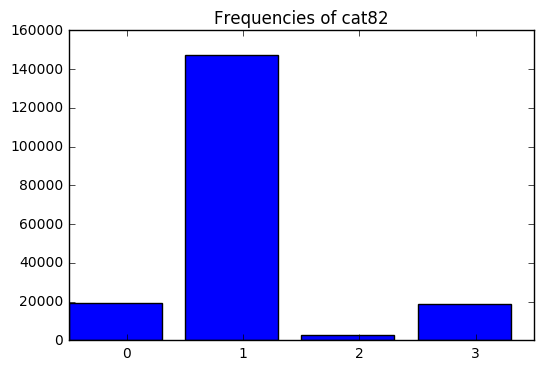

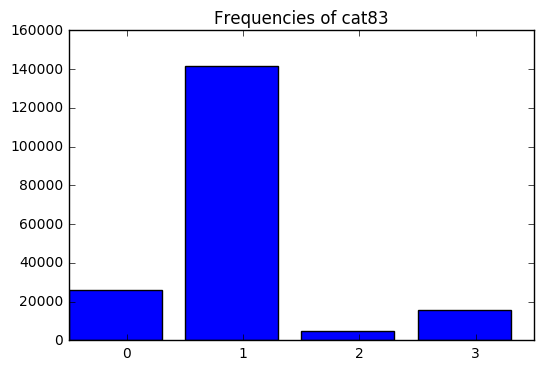

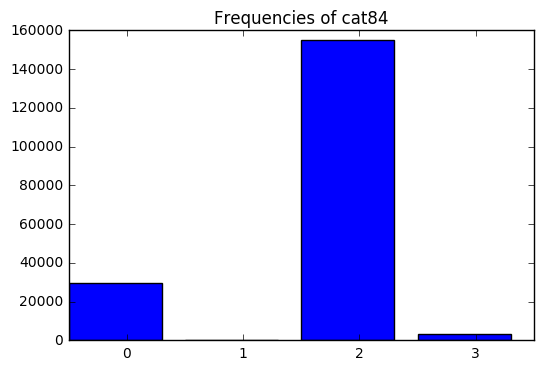

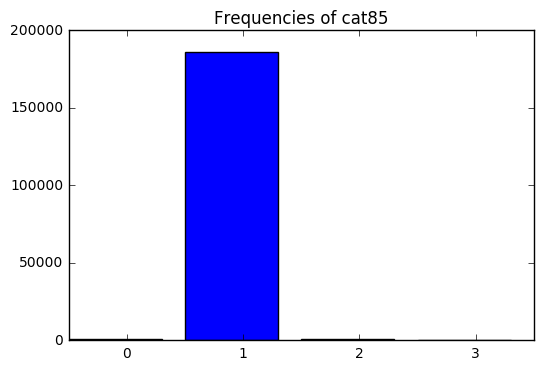

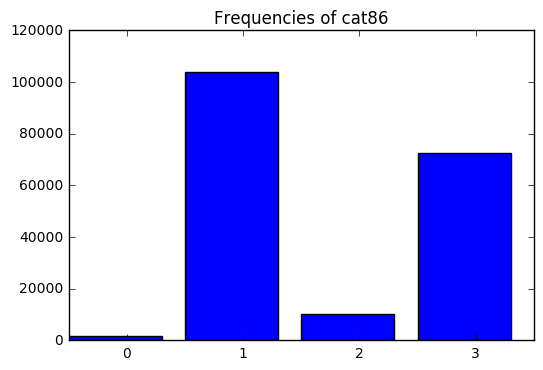

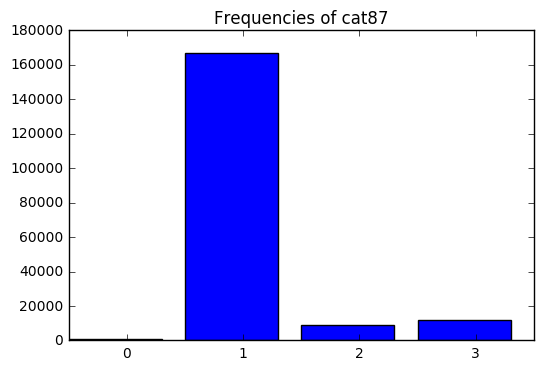

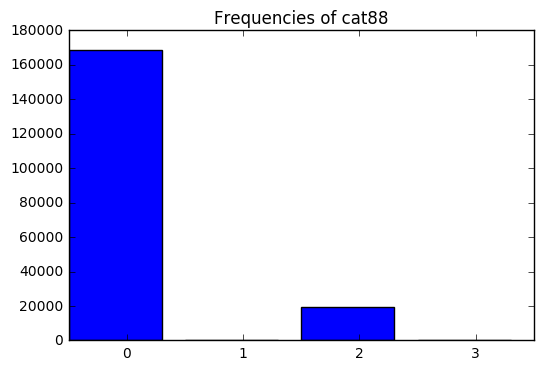

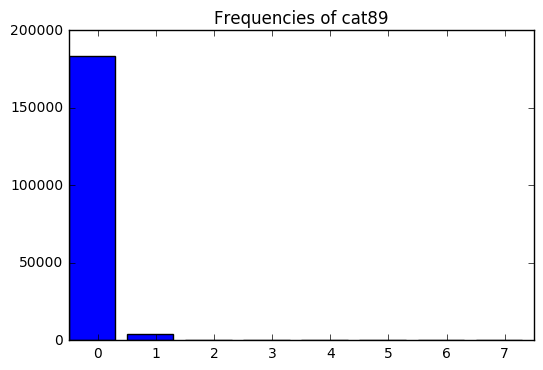

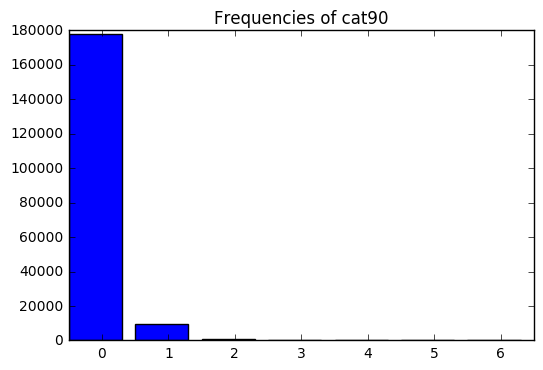

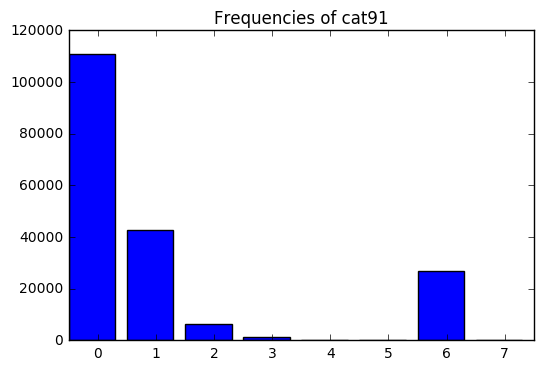

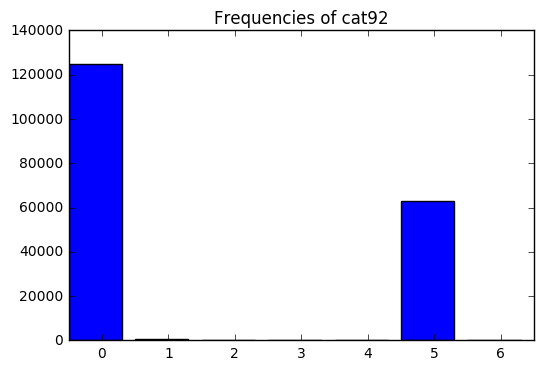

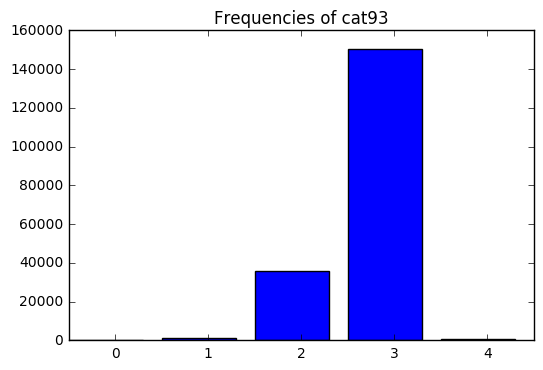

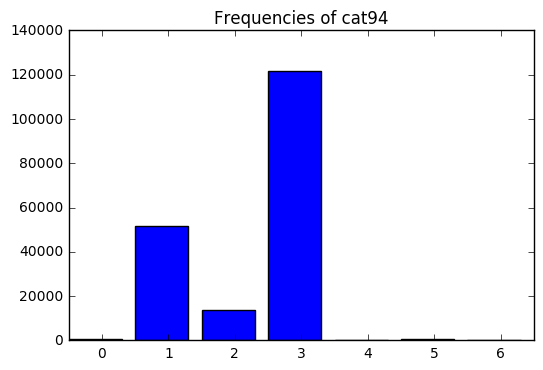

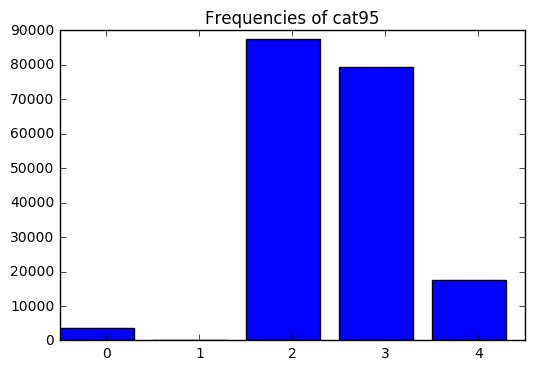

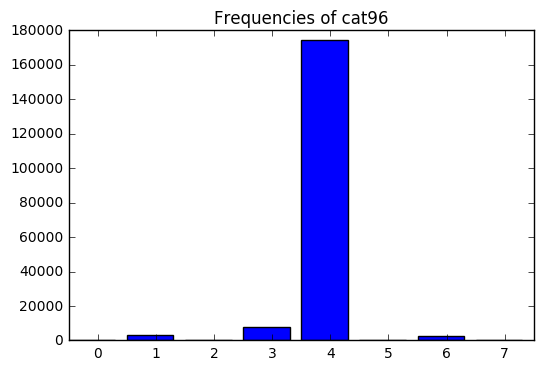

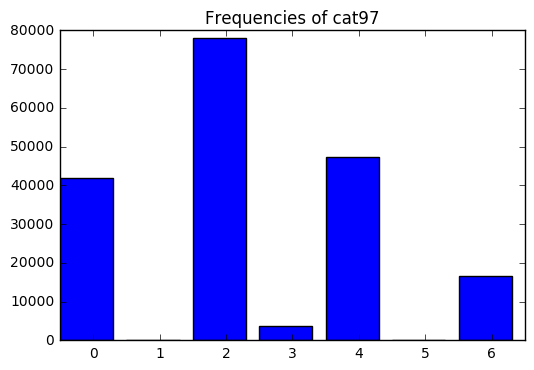

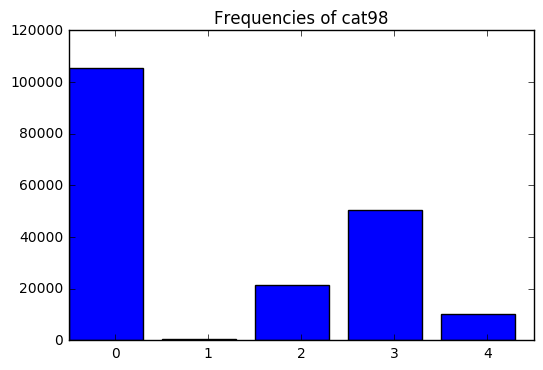

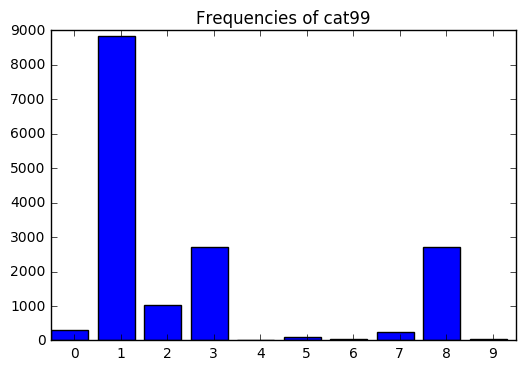

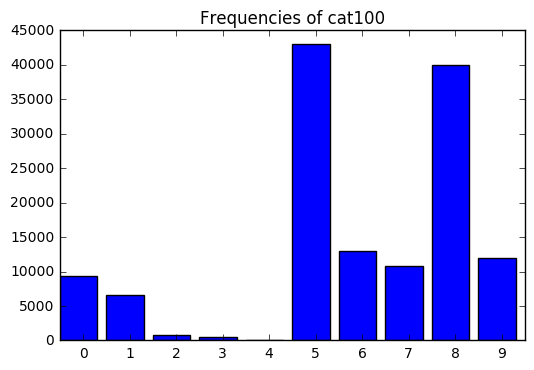

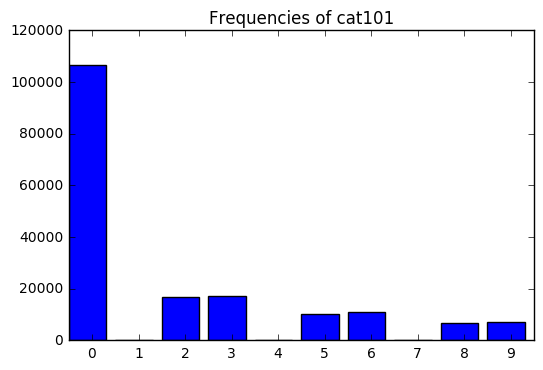

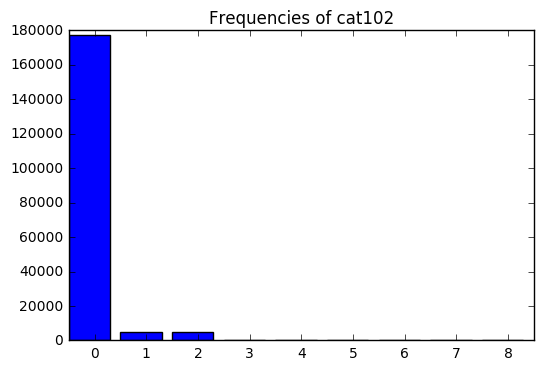

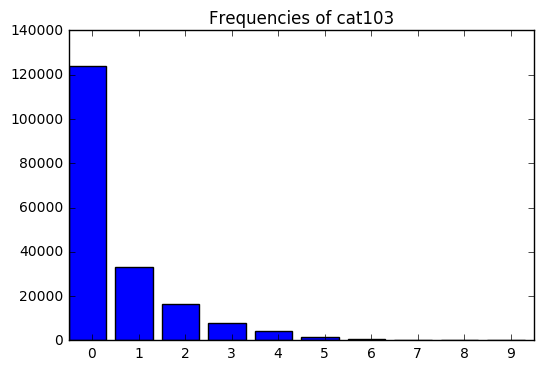

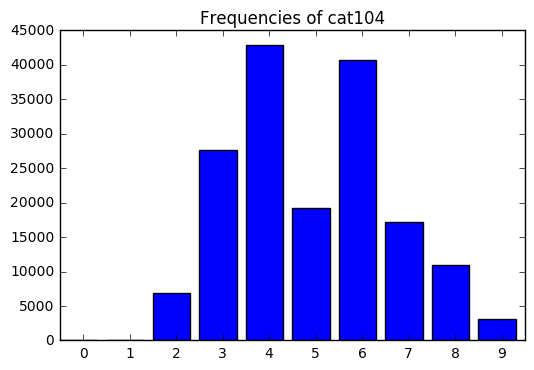

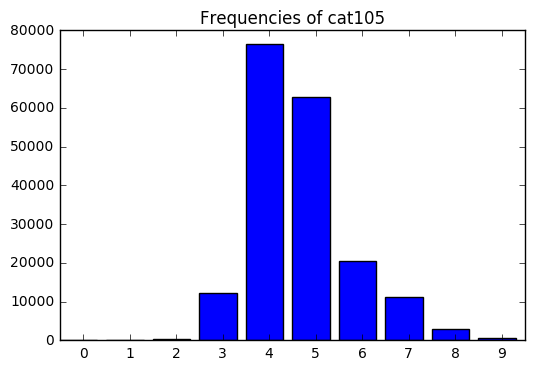

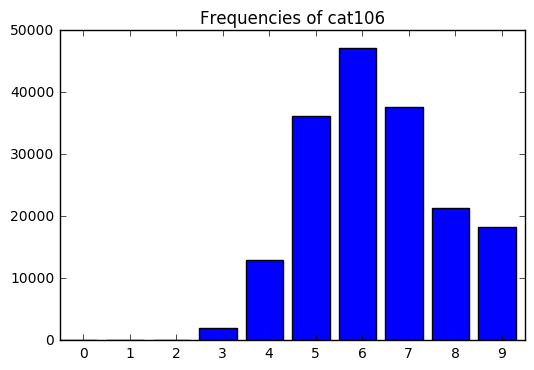

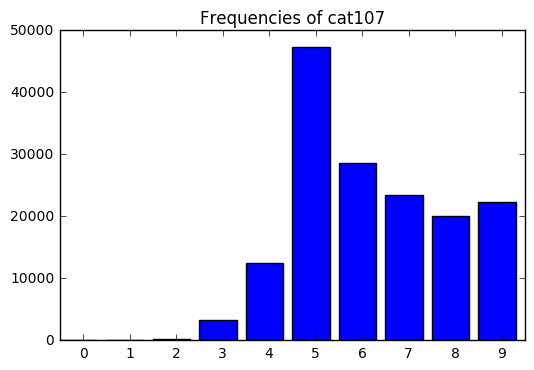

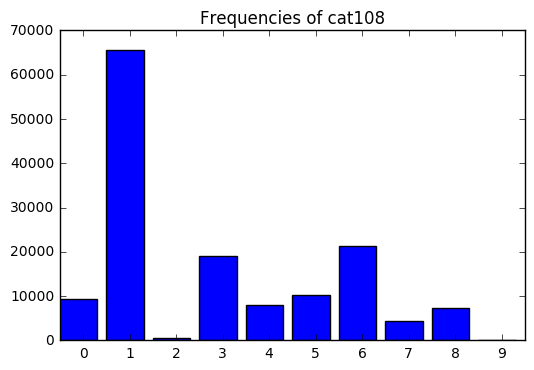

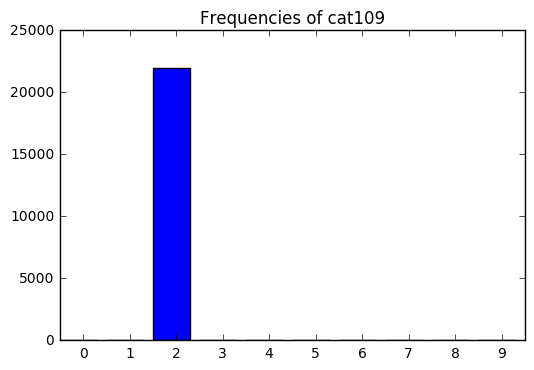

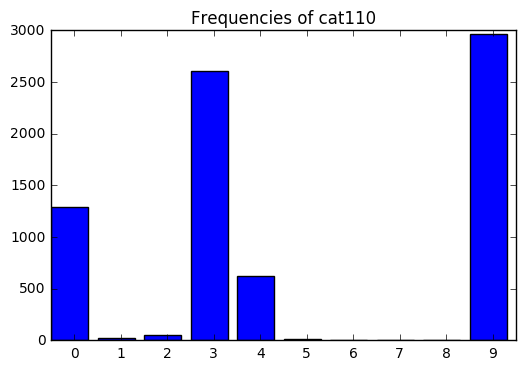

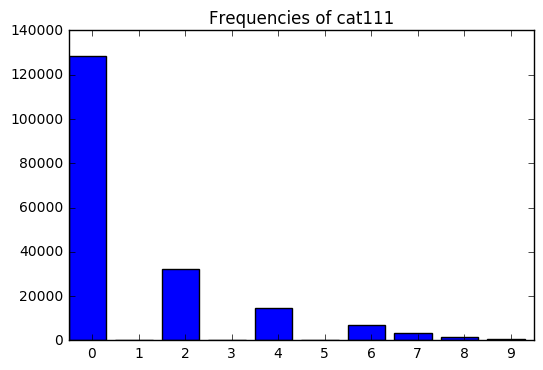

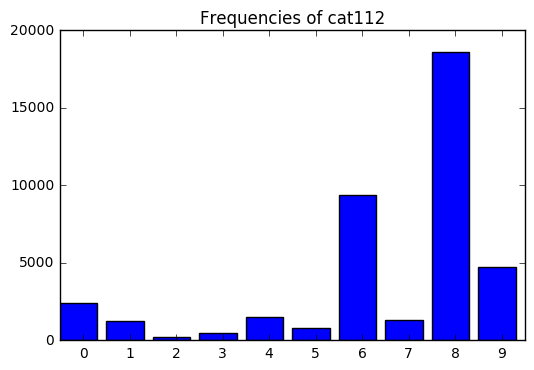

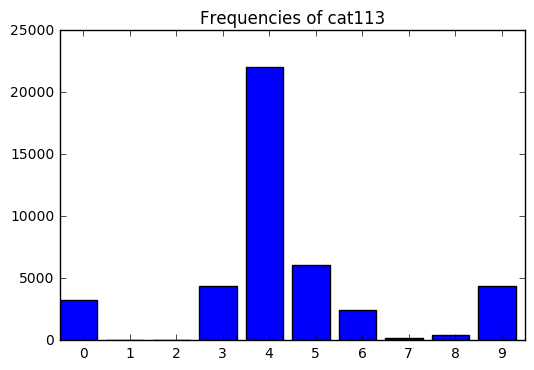

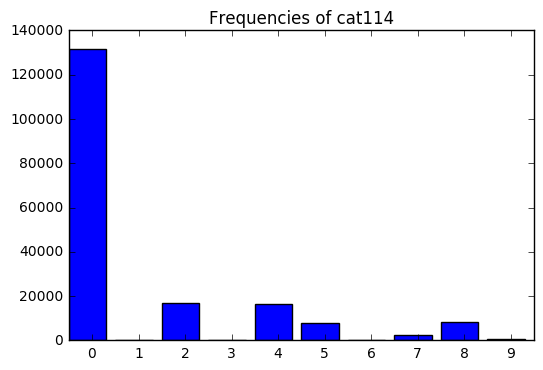

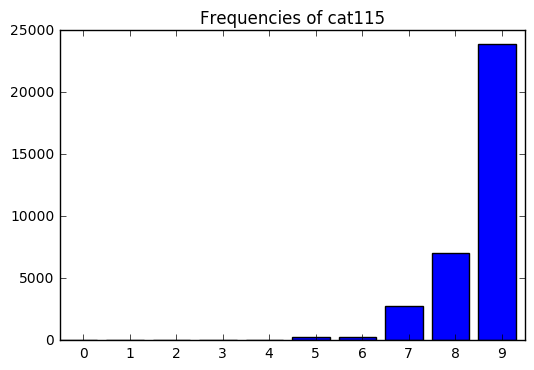

In [31]:
for i in range(1,116):
    plot_frequencies(i)

In [25]:
def plotDistribution(samples, plot=True, numSamples=100):
    vmin = min(samples)
    vmax = max(samples)
    stddev = np.std(samples)
    
    domain = np.arange(vmin, vmax, (vmax-vmin)/numSamples)
    
    # a simple heuristic to select bandwidth
    bandwidth = 1.06 * stddev * pow(len(samples), -.2)
    
    # estimate density
    kde = KDEUnivariate(samples)
    kde.fit(bw=bandwidth)
    density = kde.evaluate(domain)
    
    # plot
    # We do a little change because later we will use the data but plot it after
    if(plot):
        plt.plot(domain, density)
    else:
        return domain,density

In [26]:
def plot_loss_by_cat(idx, max_cat=4):
    # We group the losses by category and then plot a normal distributions of the result
    rdd = df.select([cat[idx-1], "loss"]).rdd.cache()

    sums = rdd.reduceByKeyLocally(add)
    
    counts_rdd = rdd.map(lambda x: (x[0],1))
    counts = counts_rdd.reduceByKeyLocally(add)
    
    square_rdd = rdd.map(lambda x: (x[0], x[1]*x[1]))
    sums_square = square_rdd.reduceByKeyLocally(add)
    
    i = 0
    for key in counts:
        
        mu = sums[key]/counts[key]
        variance = sums_square[key]/counts[key] - np.square(mu)
        
        sigma = math.sqrt(variance)
        x = np.linspace(-2*sigma + mu, 2*sigma + mu, 100)
        plt.plot(x,mlab.normpdf(x, mu, sigma))
        
        if i%max_cat == 0:
            plt.plot()
        i+=1
        
    if i%max_cat != 0:
        plt.plot()
    i+=1